In [2]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import plotly.express as px

In [55]:
# load datasets from wasatch ront forecast for the 2023 rtp
dfLinF = pd.read_csv('data/wf-forecasting-2023rtp/linear-forecasts.csv',usecols=['SEGID','YEAR','PROJGRP','linForecast'])
dfModF = pd.read_csv('data/wf-forecasting-2023rtp/model-forecasts.csv',usecols=['SEGID','YEAR','modForecast'])

dfLinF2050 = dfLinF[dfLinF['YEAR']==2050]
dfModF2050 = dfModF[dfModF['YEAR']==2050]

# Merge the two datasets based on 'SEGID'
merged_df = dfModF2050.merge(dfLinF2050, on=('SEGID','YEAR'), how='inner')

display(merged_df)

,SEGID,YEAR,modForecast,PROJGRP,linForecast
0,0006_146.9,2050,2400.0,Since 1981,1986
1,0006_146.9,2050,2400.0,Since 1981,1906
2,0006_146.9,2050,2400.0,Since 2011 w/o 2020,2717
3,0006_146.9,2050,2400.0,Since 2011 w/o 2020,2249
4,0006_146.9,2050,2400.0,Since 2001 w/o 2020,1777
...,...,...,...,...,...
21130,WFRC_8223,2050,5000.0,Since 2011 w/o 2020,3
21131,WFRC_8223,2050,5000.0,Since 2001 w/o 2020,3
21132,WFRC_8263,2050,7100.0,Since 1981,2297
21133,WFRC_8263,2050,7100.0,Since 2011 w/o 2020,-23928


In [52]:
# Define the specific order you want
desired_order = ['Since 1981', 'Since 2001 w/o 2020', 'Since 2011 w/o 2020']

# Create a new categorical column with the desired order
merged_df['PROJGRP'] = pd.Categorical(merged_df['PROJGRP'], categories=desired_order, ordered=True)


In [53]:
# Compute the squared error for each row
merged_df['SquaredError'] = (merged_df['linForecast'] - merged_df['modForecast'])**2

# Compute the RMSE quantiles by PROJGRP
quantile_values_squared = merged_df.groupby('PROJGRP')['SquaredError'].quantile(quantiles).unstack()
rmse_quantiles = np.sqrt(quantile_values_squared)

# Rename the columns for clarity
rmse_quantiles.columns = ['25th-%-tile', 'Median RMSE', '75th-%-tile']

# Optionally, add a column for mean RMSE for comparison
rmse_quantiles['Mean RMSE'] = np.sqrt(merged_df.groupby('PROJGRP')['SquaredError'].mean())

print(rmse_quantiles)


                     25th-%-tile  Median RMSE  75th-%-tile     Mean RMSE
PROJGRP                                                                 
Since 1981                1806.0       4801.0      11038.0  17557.642463
Since 2001 w/o 2020       1806.0       5255.0      12479.0  19101.993595
Since 2011 w/o 2020       1988.0       5551.0      14310.0  25840.106553


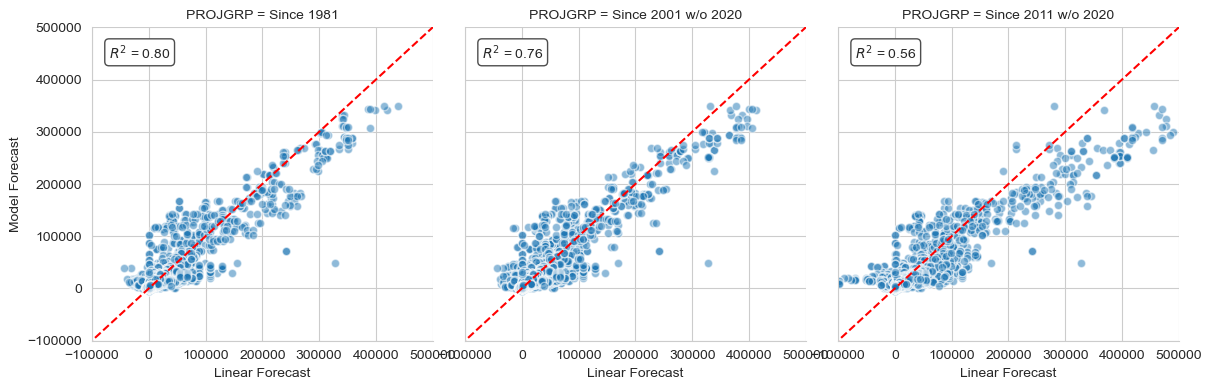

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Set up the plot aesthetics
sns.set_style("whitegrid")

# Create a grid of scatter plots, one for each PROJGRP
g = sns.FacetGrid(merged_df, col="PROJGRP", col_wrap=3, height=4, sharex=True, sharey=True)
g.map(plt.scatter, 'linForecast', 'modForecast', edgecolor="w", alpha=0.5)

# Define your limits
xmin, xmax = -100000, 500000  # Replace with your desired values
ymin, ymax = -100000, 500000  # Replace with your desired values

# Annotate each subplot with the R^2 value
for projgrp, ax in zip(g.col_names, g.axes.flat):
    group_data = merged_df[merged_df["PROJGRP"] == projgrp]
    r2 = r2_score(group_data["modForecast"], group_data["linForecast"])
    
    ax.text(0.05, 0.95, f"$R^2$ = {r2:.2f}", transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
    ax.plot((min(merged_df['linForecast']), max(merged_df['linForecast'])), 
            (min(merged_df['linForecast']), max(merged_df['linForecast'])), 
            color='red', linestyle='--')
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    ax.set_xlabel("Linear Forecast")
    ax.set_ylabel("Model Forecast")

plt.subplots_adjust(hspace=0.4)
plt.show()

Since 1981: 16.11% of segments have linear forecasts that are within 10% of a model forecast.
Since 2001 w/o 2020: 15.20% of segments have linear forecasts that are within 10% of a model forecast.
Since 2011 w/o 2020: 10.49% of segments have linear forecasts that are within 10% of a model forecast.


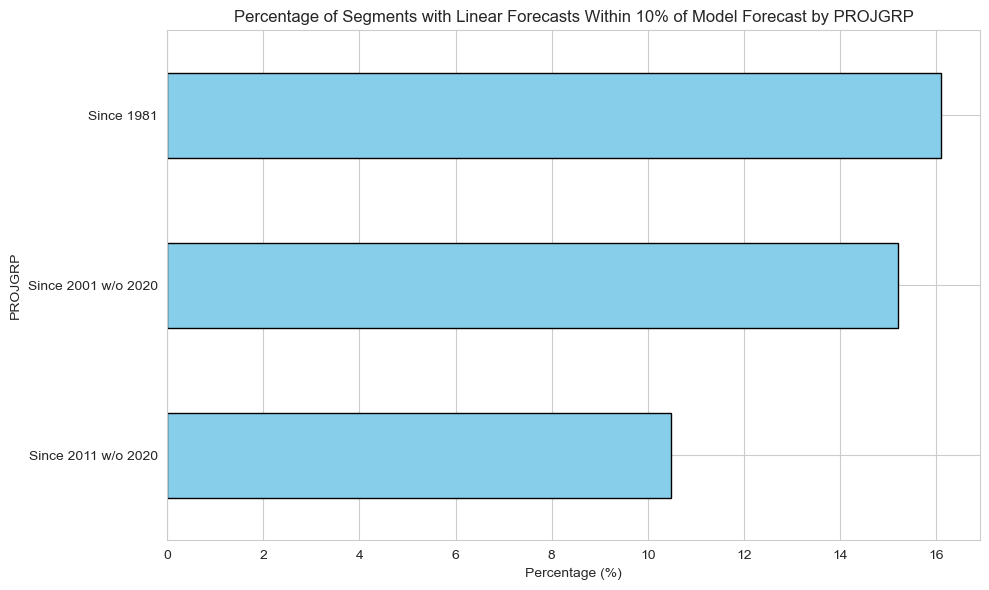

In [59]:
import matplotlib.pyplot as plt

# Calculate absolute percent error for each segment
merged_df['PercentError'] = abs((merged_df['linForecast'] - merged_df['modForecast']) / merged_df['modForecast'] * 100)

# Define a function to compute the percentage of rows with error <= 10% for each group
def percentage_within_10_percent(group):
    return (group['PercentError'] <= 10).sum() / len(group) * 100

# Apply the function to each PROJGRP
percentages = merged_df.groupby('PROJGRP').apply(percentage_within_10_percent)

# Display the results
for projgrp, percentage in percentages.items():
    print(f"{projgrp}: {percentage:.2f}% of segments have linear forecasts that are within 10% of a model forecast.")

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
percentages.sort_values().plot(kind='barh', ax=ax, color='skyblue', edgecolor='black')
ax.set_xlabel('Percentage (%)')
ax.set_title('Percentage of Segments with Linear Forecasts Within 10% of Model Forecast by PROJGRP')
plt.tight_layout()
plt.show()
